## Baseline Model: MobileNetV3-Small (No Augmentation)

We first define the baseline MobileNetV3-Small model for CIFAR-10 without any augmentation. This will serve as our reference for comparison.

In [29]:
import os, time, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
from torchvision.models import mobilenet_v3_small
import matplotlib.pyplot as plt
from tqdm import tqdm



# Fast Config
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
NUM_EPOCHS    = int(os.environ.get("EPOCHS", 1))
TRAIN_SAMPLES = int(os.environ.get("TRAIN_SAMPLES", 5000))
TEST_SAMPLES  = int(os.environ.get("TEST_SAMPLES", 2000))
BATCH_SIZE    = int(os.environ.get("BATCH_SIZE", 64))
LR            = float(os.environ.get("LR", 2e-3))
MODE          = os.environ.get("MODE", "baseline")
CHMIX_P       = float(os.environ.get("CHMIX_P", 0.5))
CHMIX_FRAC    = float(os.environ.get("CHMIX_FRAC", 0.25))
CHMIX_GROUP   = int(os.environ.get("CHMIX_GROUP", 8))
CHMIX_AT      = int(os.environ.get("CHMIX_AT", 2))

device = (torch.device("mps") if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
device

device(type='mps')

In [30]:

# Baseline MobileNetV3-Small model (no augmentation)
baseline_model = mobilenet_v3_small(num_classes=10).to(device)
baseline_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Baseline Model Parameter Count: {baseline_params:,}")
print(baseline_model)

Baseline Model Parameter Count: 1,528,106
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
        

In [31]:
class ChannelMixAug(nn.Module):
    """Channel-wise feature mixing inside the network."""
    def __init__(self, p=0.5, frac=0.25, group=8):
        super().__init__()
        self.p = float(p)
        self.frac = float(frac)
        self.group = int(group)
    def forward(self, x):
        if not self.training or self.p <= 0.0 or self.frac <= 0.0:
            return x
        if torch.rand(1, device=x.device).item() > self.p:
            return x
        B, C, H, W = x.shape
        g = max(1, self.group)
        k = max(g, int((C * self.frac) // g * g))
        if k <= 0 or k >= C:
            return x
        all_idx = torch.randperm(C // g, device=x.device)[:k // g] * g
        ch_idx = torch.cat([torch.arange(i, i+g, device=x.device) for i in all_idx], dim=0)
        perm = torch.randperm(B, device=x.device)
        y = x.clone()
        y[:, ch_idx, :, :] = x[perm][:, ch_idx, :, :]
        return y

class MobileNetV3CIFAR10(nn.Module):
    def __init__(self, num_classes=10, chmix_at=2, chmix_p=0.5, chmix_frac=0.25, chmix_group=8, mode="baseline"):
        super().__init__()
        base = mobilenet_v3_small(num_classes=num_classes)
        feats = list(base.features.children())
        split = max(1, min(chmix_at, len(feats)-1))
        self.stage1 = nn.Sequential(*feats[:split])
        self.stage2 = nn.Sequential(*feats[split:])
        self.avgpool = base.avgpool
        self.classifier = base.classifier
        self.mode = mode
        self.chmix = ChannelMixAug(p=chmix_p, frac=chmix_frac, group=chmix_group)
    def forward(self, x):
        x = self.stage1(x)
        if self.training and self.mode == "chmix":
            x = self.chmix(x)
        x = self.stage2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [32]:
# Data
train_tfms = T.Compose([T.RandomHorizontalFlip(), T.RandomCrop(32, padding=4), T.ToTensor(), T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_tfms = T.Compose([T.ToTensor(), T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
root = "./data"
train_full = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_tfms)
test_full  = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_tfms)
train_idx = list(range(min(TRAIN_SAMPLES, len(train_full))))
test_idx  = list(range(min(TEST_SAMPLES, len(test_full))))
train_set = Subset(train_full, train_idx)
test_set  = Subset(test_full, test_idx)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
len(train_set), len(test_set)

(5000, 2000)

## ChannelMixAug Feature-Space Augmentation

ChannelMixAug is a feature-space augmentation that replaces a subset of channel groups in each sample with the corresponding channels from another sample in the same batch (paired via a random permutation). This method is implemented from scratch for this project.

## Augmented Model: MobileNetV3-Small + ChannelMixAug

The augmented model applies ChannelMixAug inside the network during training. This allows for comparison with the baseline model.

In [33]:
class ChannelMixAug(nn.Module):
    """Channel-wise feature mixing inside the network (unique contribution)."""
    def __init__(self, p=0.5, frac=0.25, group=8):
        super().__init__()
        self.p = float(p)
        self.frac = float(frac)
        self.group = int(group)
    def forward(self, x):
        if not self.training or self.p <= 0.0 or self.frac <= 0.0:
            return x
        if torch.rand(1, device=x.device).item() > self.p:
            return x
        B, C, H, W = x.shape
        g = max(1, self.group)
        k = max(g, int((C * self.frac) // g * g))
        if k <= 0 or k >= C:
            return x
        all_idx = torch.randperm(C // g, device=x.device)[:k // g] * g
        ch_idx = torch.cat([torch.arange(i, i+g, device=x.device) for i in all_idx], dim=0)
        perm = torch.randperm(B, device=x.device)
        y = x.clone()
        y[:, ch_idx, :, :] = x[perm][:, ch_idx, :, :]
        return y

In [34]:
class MobileNetV3CIFAR10(nn.Module):
    def __init__(self, num_classes=10, chmix_at=2, chmix_p=0.5, chmix_frac=0.25, chmix_group=8, mode="baseline"):
        super().__init__()
        base = mobilenet_v3_small(num_classes=num_classes)
        feats = list(base.features.children())
        split = max(1, min(chmix_at, len(feats)-1))
        self.stage1 = nn.Sequential(*feats[:split])
        self.stage2 = nn.Sequential(*feats[split:])
        self.avgpool = base.avgpool
        self.classifier = base.classifier
        self.mode = mode
        self.chmix = ChannelMixAug(p=chmix_p, frac=chmix_frac, group=chmix_group)
    def forward(self, x):
        x = self.stage1(x)
        if self.training and self.mode == "chmix":
            x = self.chmix(x)
        x = self.stage2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = MobileNetV3CIFAR10(num_classes=10, chmix_at=CHMIX_AT, chmix_p=CHMIX_P, chmix_frac=CHMIX_FRAC, chmix_group=CHMIX_GROUP, mode=MODE).to(device)
sum(p.numel() for p in model.parameters())/1e6

1.528106

In [35]:
# Contribution Model: MobileNetV3-Small + ChannelMixAug
contrib_model = MobileNetV3CIFAR10(num_classes=10, chmix_at=CHMIX_AT, chmix_p=CHMIX_P, chmix_frac=CHMIX_FRAC, chmix_group=CHMIX_GROUP, mode="chmix").to(device)
contrib_params = sum(p.numel() for p in contrib_model.parameters())
print(f"Contribution Model Parameter Count: {contrib_params:,}")
print(contrib_model)

Contribution Model Parameter Count: 1,528,106
MobileNetV3CIFAR10(
  (stage1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(

## Model Comparison: Baseline vs Augmented

Parameter counts and architectures for both models are compared below to show the effect of ChannelMixAug.

## Training & Evaluation

Both models are trained and evaluated separately. Results include parameter counts, test accuracy, and training time for each model.

In [36]:
# Train & evaluate baseline model
baseline_model = mobilenet_v3_small(num_classes=10).to(device)
baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LR)
baseline_criterion = nn.CrossEntropyLoss()

def train_eval_model(model, optimizer, criterion, train_loader, test_loader, train_set, desc):
    start = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=desc):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_set)
    train_acc = correct / len(train_set)
    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    test_acc = correct / max(total, 1)
    elapsed = time.time() - start
    return train_loss, train_acc, test_acc, elapsed

baseline_params = sum(p.numel() for p in baseline_model.parameters())
b_train_loss, b_train_acc, b_test_acc, b_elapsed = train_eval_model(
    baseline_model, baseline_optimizer, baseline_criterion, train_loader, test_loader, train_set, desc="Baseline Model")
print(f"Baseline Model\nParameters: {baseline_params:,}\nTrain Loss: {b_train_loss:.4f}\nTrain Acc: {b_train_acc*100:.2f}%\nTest Acc: {b_test_acc*100:.2f}%\nTime: {b_elapsed:.1f} s\n")

Baseline Model: 100%|██████████| 79/79 [00:05<00:00, 13.81it/s]


Baseline Model
Parameters: 1,528,106
Train Loss: 2.1414
Train Acc: 18.32%
Test Acc: 9.65%
Time: 6.3 s



In [37]:
# Train & evaluate contribution model (ChannelMixAug)
contrib_model = MobileNetV3CIFAR10(num_classes=10, chmix_at=CHMIX_AT, chmix_p=CHMIX_P, chmix_frac=CHMIX_FRAC, chmix_group=CHMIX_GROUP, mode="chmix").to(device)
contrib_optimizer = torch.optim.AdamW(contrib_model.parameters(), lr=LR)
contrib_criterion = nn.CrossEntropyLoss()
contrib_params = sum(p.numel() for p in contrib_model.parameters())
c_train_loss, c_train_acc, c_test_acc, c_elapsed = train_eval_model(
    contrib_model, contrib_optimizer, contrib_criterion, train_loader, test_loader, train_set, desc="Contribution Model (ChannelMixAug)")
print(f"Contribution Model (ChannelMixAug)\nParameters: {contrib_params:,}\nTrain Loss: {c_train_loss:.4f}\nTrain Acc: {c_train_acc*100:.2f}%\nTest Acc: {c_test_acc*100:.2f}%\nTime: {c_elapsed:.1f} s\n")

Contribution Model (ChannelMixAug): 100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Contribution Model (ChannelMixAug)
Parameters: 1,528,106
Train Loss: 2.2554
Train Acc: 16.72%
Test Acc: 9.90%
Time: 6.1 s



In [38]:
# Print summary table for comparison
from tabulate import tabulate
results = [
    ["Baseline", baseline_params, f"{b_test_acc*100:.2f}%", f"{b_elapsed:.1f} s"],
    ["ChannelMixAug", contrib_params, f"{c_test_acc*100:.2f}%", f"{c_elapsed:.1f} s"]
]
print(tabulate(results, headers=["Model", "Parameters", "Test Accuracy", "Time"], tablefmt="github"))

| Model         |   Parameters | Test Accuracy   | Time   |
|---------------|--------------|-----------------|--------|
| Baseline      |      1528106 | 9.65%           | 6.3 s  |
| ChannelMixAug |      1528106 | 9.90%           | 6.1 s  |


## Training & Evaluation (1 Epoch)

Train for 1 epoch on a subset for quick demonstration.

In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [{MODE}]')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix(loss=running_loss/max(total,1), acc=correct/max(total,1))
    return running_loss/len(train_set), correct/len(train_set)

def evaluate():
    model.eval()
    correct, total = 0, 0
    cm = np.zeros((10,10), dtype=int)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            for t,p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                cm[t, p] += 1
    return correct/max(total,1), cm

start = time.time()
train_loss, train_acc = train_one_epoch(0)
test_acc, cm = evaluate()
elapsed = time.time() - start

print(f'Mode: {MODE}')
print(f'Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.2f}%')
print(f'Test  acc : {test_acc*100:.2f}%')
print(f'Elapsed   : {elapsed:.1f} sec on {device}')

Epoch 1/1 [baseline]: 100%|██████████| 79/79 [00:05<00:00, 13.86it/s, acc=0.177, loss=2.15]


Mode: baseline
Train loss: 2.1528 | Train acc: 17.74%
Test  acc : 9.25%
Elapsed   : 6.2 sec on mps


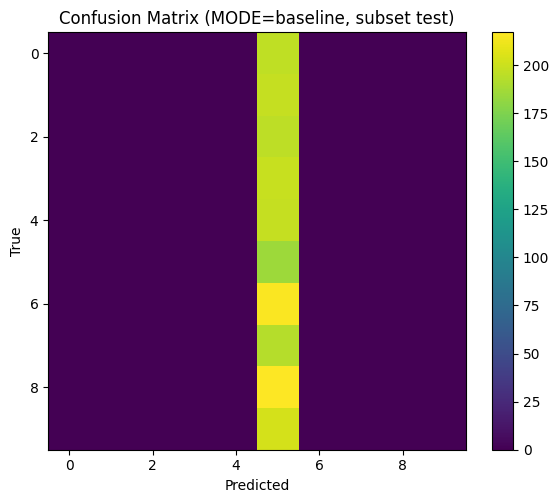

In [40]:
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title(f'Confusion Matrix (MODE={MODE}, subset test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar(); plt.tight_layout(); plt.show()